In [1]:
import openai
import os
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

openai.api_key = os.environ['OPENAI_API_KEY']


In [30]:
def request_gpt(input_str) :

    chatgpt_sys_message = "You are a helpful assistant that performs time series predictions. The user will provide a sequence and you will predict the remaining sequence. The sequence is represented by decimal strings separated by commas."
    extra_input = "Please continue the following sequence without producing any additional text. Do not say anything like 'the next terms in the sequence are', just return the 7 following numbers. Sequence:\n"




    response = openai.ChatCompletion.create(
                model= "gpt-4-vision-preview",
                messages=[
                        {"role": "system", "content": chatgpt_sys_message},
                        {"role": "user", "content": extra_input + input_str}
                    ],
                temperature=1.0,
                n=10,
            )

    list_response = [choice.message.content for choice in response.choices]
    return list_response

def request_gpt_bin(input_str) :

    chatgpt_sys_message = "You are a helpful assistant that performs time series predictions. The user will provide a sequence and you will predict the remaining sequence. The sequence is represented by decimal strings separated by commas."
    extra_input = "Please continue the following sequence without producing any additional text. Do not say anything like 'the next terms in the sequence are', just return the 7 following bin. Sequence:\n"
    gpt_bin_message = "The trend is represented by bins \"D10+\", \"D10\", \"D8\", \"D6\", \"D4\", \"D2\", \"U2\", \"U4\", \"U6\", \"U8\", \"U10\", \"U10+\", where \"D10+\" means price dropping more than 10%, D10 means price dropping between 8% and 10%, \"D8\" means price dropping between 6% and 8%, \"U10+\" means price rising more than 10%, \"U10\" means price rising between 8% and 10%, \"D8\" means price rising between 6% and 8%, etc."




    response = openai.ChatCompletion.create(
                model= "gpt-4-vision-preview",
                messages=[
                        {"role": "system", "content": chatgpt_sys_message},
                        {"role": "user", "content": gpt_bin_message + extra_input + input_str}
                    ],
                temperature=1.0,
                n=10,
            )

    list_response = [choice.message.content for choice in response.choices]
    return list_response

In [90]:
gpt_bin_message = "The trend is represented by bins \"D10+\", \"D10\", \"D8\", \"D6\", \"D4\", \"D2\", \"U2\", \"U4\", \"U6\", \"U8\", \"U10\", \"U10+\", where \"D10+\" means price dropping more than 10%, D10 means price dropping between 8% and 10%, \"D8\" means price dropping between 6% and 8%, \"U10+\" means price rising more than 10%, \"U10\" means price rising between 8% and 10%, \"D8\" means price rising between 6% and 8%, etc."
print(gpt_bin_message)

The trend is represented by bins "D10+", "D10", "D8", "D6", "D4", "D2", "U2", "U4", "U6", "U8", "U10", "U10+", where "D10+" means price dropping more than 10%, D10 means price dropping between 8% and 10%, "D8" means price dropping between 6% and 8%, "U10+" means price rising more than 10%, "U10" means price rising between 8% and 10%, "D8" means price rising between 6% and 8%, etc.


In [63]:
def str_convert(data) :
    final_str = ""
    for elt in data :
        str_number = str(round(elt))
        final_str = final_str + str_number + ", "
    return final_str


def plot_preds_candles(df, train, test, pred, model_name, show_samples=False, savefig = ""):

    save_folder = "./plot/" + savefig
    index = len(train)

    opens = pd.Series(df['open'].values, index=df['date'])
    truth = pd.Series(df['close'].values, index=df['date'])
    highs = pd.Series(df['high'].values, index=df['date'])
    lows = pd.Series(df['low'].values, index=df['date'])

    plt.figure(figsize=(8, 6), dpi=100)

    ## Draw candles
    height = truth - opens
    bottom = np.where(height > 0, opens, truth + abs(height))
    color = np.where(height > 0, 'g', 'r')

    plt.bar(range(len(truth)), height, bottom=bottom, color=color, align='center')
    plt.vlines(range(len(highs)), ymin=lows, ymax=highs, color=color, linewidth=1)      

    lower = np.quantile(pred, 0.05, axis=0)
    upper = np.quantile(pred, 0.95, axis=0)
    plt.fill_between(range(index, index + len(lower)), lower, upper, alpha=0.3, color='purple')

    medians = [sorted(sublist)[len(sublist)//2] if len(sublist) % 2 != 0 else
           (sorted(sublist)[len(sublist)//2 - 1] + sorted(sublist)[len(sublist)//2]) / 2
           for sublist in zip(*pred)]  

    plt.plot(range(index, index + len(pred[0])), medians, label=model_name, color='purple')
    

    # plt.plot(range(index, index + len(pred[0])), pred[0], label=model_name, color='purple')
    plt.grid()
    plt.legend(loc='upper left')

    index_to_display = range(0, len(truth), len(truth) // 3)
    truth.index = truth.index.date
    display_date = truth.index[index_to_display]
    plt.xticks(index_to_display, display_date)

    # plt.xticks(range(len(truth)), truth.index)

    plt.savefig(save_folder)
    plt.show()


def get_data_set(name, input_length, start_date, end_date) :
    with open(name) as f:
        df = pd.read_csv(f, usecols=[0, 4], parse_dates=[0])
        mask = (df["date"] >= start_date) & (df["date"] <= end_date)
        df = df.loc[mask]
        df['close'] = df['close'].astype(float)
        series = pd.Series(df['close'].values, index=df['date'])

        f.seek(0)
        df_raw = pd.read_csv(f, parse_dates=[0])
        df_raw = df_raw.loc[mask]

        splitpoint = input_length
        train = series.iloc[:splitpoint]
        test = series.iloc[splitpoint:]

    return (df_raw, train, test)

def get_data_set_return(name, input_length, start_date, end_date) :
    with open(name) as f:
        df = pd.read_csv(f, usecols=[0, 1, 4], parse_dates=[0])
        mask = (df["date"] >= start_date) & (df["date"] <= end_date)
        df = df.loc[mask]
        df['close'] = df['close'].astype(float)
        df['open'] = df['open'].astype(float)
        df['return'] = ((df['close'] / df['open']) - 1) * 10000
        df = df[['date', 'return']]

        series = pd.Series(df['return'].values, index=df['date'])

        splitpoint = input_length
        train = series.iloc[:splitpoint]
        test = series.iloc[splitpoint:]

        f.seek(0)
        df_raw = pd.read_csv(f, parse_dates=[0])
        df_raw = df_raw.loc[mask]
        df_raw['close'] = df_raw['close'].astype(float)
        df_raw['open'] = df_raw['open'].astype(float)
        df_raw['return'] = ((df_raw['close'] / df_raw['open']) - 1) * 10000
        
    return (df_raw, train, test)


def basic_seriealize(list_response) :
    dic_int_list = []
    for elt in list_response :
        try :
            sub_chains = elt.split(',')
            int_list = [int(sub_chain.strip()) for sub_chain in sub_chains]
            if (len(int_list) > 7) :
                int_list = int_list[:7]
            elif (len(int_list) < 7) :
                last_numb = int_list[-1]
                while (len(int_list) < 7) :
                    int_list.append(last_numb)
            dic_int_list.append(int_list)
        except :
            print("error in serialization")
            continue
    return dic_int_list


def bin_seriealize(list_response) :
    final_dic_int_list = []
    for elt in list_response :
        try :
            sub_chains = elt.split(',')
            dic_int_list = []
            for sub_chain in sub_chains :
                without_space = sub_chain.replace(" ", "")
                if (without_space == "U2") :
                    dic_int_list.append(1)
                elif (without_space == "U4") :
                    dic_int_list.append(3)
                elif (without_space == "U6") :
                    dic_int_list.append(5)
                elif (without_space == "U8") :
                    dic_int_list.append(7)
                elif (without_space == "U10") :
                    dic_int_list.append(9)
                elif (without_space == "U10+") :
                    dic_int_list.append(11)
                elif (without_space == "D2") :
                    dic_int_list.append(-1)
                elif (without_space == "D4") :
                    dic_int_list.append(-3)
                elif (without_space == "D6") :
                    dic_int_list.append(-5)
                elif (without_space == "D8") :
                    dic_int_list.append(-7)
                elif (without_space == "D10") :
                    dic_int_list.append(-9)
                elif (without_space == "D10+") :
                    dic_int_list.append(-11)
                else :
                    print("error : ", without_space)

            if (len(dic_int_list) > 7) :
                dic_int_list = dic_int_list[:7]
            elif (len(dic_int_list) < 7) :
                last_numb = dic_int_list[-1]
                while (len(dic_int_list) < 7) :
                    dic_int_list.append(last_numb)
            final_dic_int_list.append(dic_int_list)
        except :
            print("error in seriealization : ")
            continue
    
    return final_dic_int_list

def convert_bin_to_close(final_dic_int_list, df_raw, input_length) :
    final_dic = []
    col_index = df_raw.columns.get_loc('close')
    row_index = input_length - 1
    close = df_raw.iloc[row_index, col_index]
    for elt_l in final_dic_int_list :
        memory = close
        dic = []
        for elt in elt_l :
            dic.append(int(memory * (1 + 0.01* elt)))
            memory = dic[-1]
        final_dic.append(dic)
    return final_dic
        
def convert_return_to_close(final_dic_int_list, df_raw, input_length) :
    final_dic = []
    col_index = df_raw.columns.get_loc('close')
    row_index = input_length - 1
    open = df_raw.iloc[row_index, col_index]
    for elt_l in final_dic_int_list :
        memory = open
        dic = []
        for elt in elt_l :
            dic.append(float((elt/10000 + 1) * memory))
            memory = dic[-1]
        final_dic.append(dic)
    return final_dic

In [ ]:
def MAE_MSE_calculator(pred_dict, df_raw, index) :
    full_Mae_dict = []
    full_Mse_dict = []
    col_index = df_raw.columns.get_loc('close')

    for list_elt in pred_dict :
        Mae_dict = []
        Mse_dict = []

        for i,elt in enumerate(list_elt) :
            row_index = i + index
            Mae_dict.append(np.abs(elt - df_raw.iloc[row_index, col_index]))
            Mse_dict.append(np.power(elt - df_raw.iloc[row_index, col_index]))

        full_Mae_dict.append(Mae_dict)
        full_Mse_dict.append(Mse_dict)

    return full_Mae_dict, full_Mse_dict

def Specific_return(dict, indice) :
    return np.sum(dict[:indice])

Input str :  34152, 33893, 34081, 34526, 34476, 34641, 
GPT Answer :  ['34903, 34870, 35234, 35211, 35482, 35576, 35743', '34349, 34209, 34406, 34860, 34819, 34993, 34710', '34601, 34766, 34716, 34881, 34831, 34996, 34946', '34407, 34348, 34195, 34272, 34539, 34611, 34682', '34622, 34582, 34541, 34539, 34496, 34474, 34451', '34683, 34909, 35008, 35240, 35286, 35515, 35627', '34610, 34748, 34798, 34963, 34933, 35071, 35121', '34751, 34512, 34999, 35217, 34888, 35318, 35753', '34703, 34993, 34940, 35052, 35099, 35386, 35330', '34602, 34783, 34868, 34929, 35106, 35301, 35422']
serialized list :  [[34903, 34870, 35234, 35211, 35482, 35576, 35743], [34349, 34209, 34406, 34860, 34819, 34993, 34710], [34601, 34766, 34716, 34881, 34831, 34996, 34946], [34407, 34348, 34195, 34272, 34539, 34611, 34682], [34622, 34582, 34541, 34539, 34496, 34474, 34451], [34683, 34909, 35008, 35240, 35286, 35515, 35627], [34610, 34748, 34798, 34963, 34933, 35071, 35121], [34751, 34512, 34999, 35217, 34888, 35318,

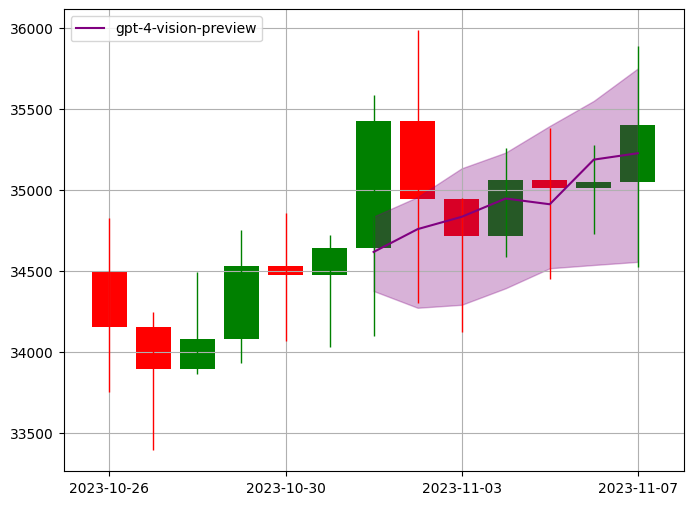

Input str :  29670, 29910, 29993, 33070, 33922, 34496, 34152, 33893, 34081, 34526, 34476, 34641, 
GPT Answer :  ['34975, 35136, 35548, 35719, 35908, 36113, 36322', '34636, 34631, 34626, 34621, 34616, 34611, 34606', '34585, 34673, 34619, 34698, 34654, 34687, 34660', '34591, 34756, 34706, 34871, 34821, 34986, 34936', '34715, 34862, 34904, 34982, 35047, 35071, 35123', '34687, 34732, 34718, 34711, 34713, 34715, 34714', '34689, 34753, 34913, 35078, 35146, 35174, 35231', '34690, 34740, 34789, 34839, 34889, 34938, 34988', '34599, 34644, 34630, 34562, 34511, 34456, 34412', '34682, 34738, 34787, 34829, 34864, 34893, 34917']
serialized list :  [[34975, 35136, 35548, 35719, 35908, 36113, 36322], [34636, 34631, 34626, 34621, 34616, 34611, 34606], [34585, 34673, 34619, 34698, 34654, 34687, 34660], [34591, 34756, 34706, 34871, 34821, 34986, 34936], [34715, 34862, 34904, 34982, 35047, 35071, 35123], [34687, 34732, 34718, 34711, 34713, 34715, 34714], [34689, 34753, 34913, 35078, 35146, 35174, 35231], 

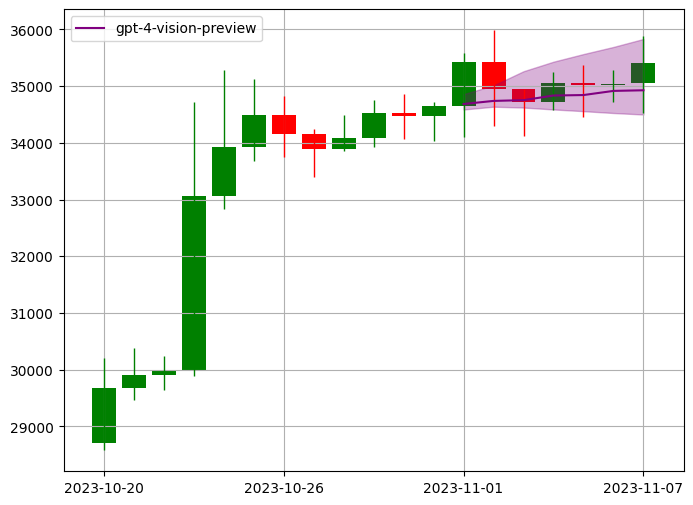

Input str :  27917, 27590, 27390, 26875, 26759, 26862, 26853, 27155, 28502, 28396, 28320, 28715, 29670, 29910, 29993, 33070, 33922, 34496, 34152, 33893, 34081, 34526, 34476, 34641, 
GPT Answer :  ['34760, 34922, 35011, 35270, 35496, 35752, 35993', '34601, 34721, 34781, 34856, 34826, 34911, 34931', '34601, 34542, 34523, 34490, 34522, 34618, 34731', '34592, 34586, 34738, 34961, 35157, 35317, 35459', '34601, 34750, 34714, 34842, 34792, 34882, 34864', '34724, 34903, 34983, 35102, 35330, 35421, 35510', '34743, 34888, 34836, 34909, 35018, 34964, 35035', '35008, 35402, 35821, 36347, 36639, 36979, 37130', '34710, 34645, 34617, 34621, 34590, 34617, 34678', '34615, 34670, 34727, 34783, 34840, 34896, 34953']
serialized list :  [[34760, 34922, 35011, 35270, 35496, 35752, 35993], [34601, 34721, 34781, 34856, 34826, 34911, 34931], [34601, 34542, 34523, 34490, 34522, 34618, 34731], [34592, 34586, 34738, 34961, 35157, 35317, 35459], [34601, 34750, 34714, 34842, 34792, 34882, 34864], [34724, 34903, 349

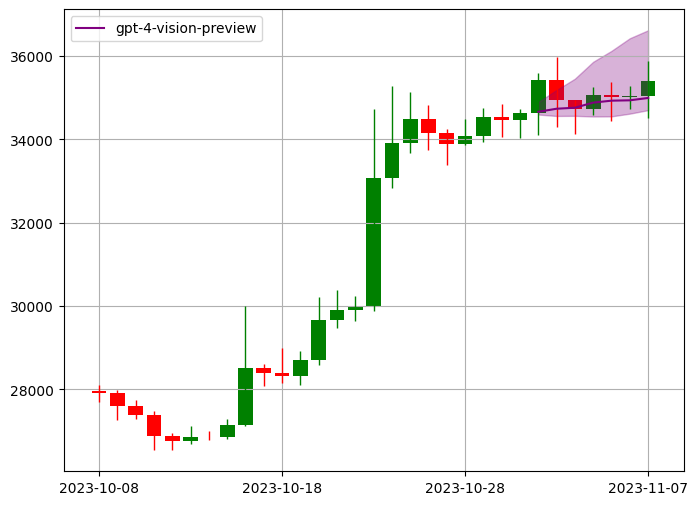

Input str :  26523, 26600, 26560, 26528, 26763, 27210, 27125, 26568, 26580, 26576, 26248, 26304, 26221, 26372, 27022, 26907, 26963, 27993, 27495, 27427, 27779, 27411, 27932, 27957, 27917, 27590, 27390, 26875, 26759, 26862, 26853, 27155, 28502, 28396, 28320, 28715, 29670, 29910, 29993, 33070, 33922, 34496, 34152, 33893, 34081, 34526, 34476, 34641, 
GPT Answer :  ['34567, 34523, 34685, 34710, 34735, 34792, 34825', '34607, 34870, 35015, 35149, 35493, 35722, 36010', '34585, 34605, 34602, 34587, 34607, 34609, 34606', '34558, 34435, 34299, 34376, 34451, 34480, 34508', '34722, 34808, 34897, 34989, 35084, 35182, 35283', '35061, 35481, 35599, 35844, 36109, 36163, 36187', '34615, 34550, 34430, 34378, 34325, 34280, 34231', '34587, 34509, 34719, 34696, 34782, 34913, 35002', '34676, 34711, 34746, 34781, 34816, 34851, 34886', '34684, 34702, 34673, 34649, 34660, 34705, 34740']
serialized list :  [[34567, 34523, 34685, 34710, 34735, 34792, 34825], [34607, 34870, 35015, 35149, 35493, 35722, 36010], [34

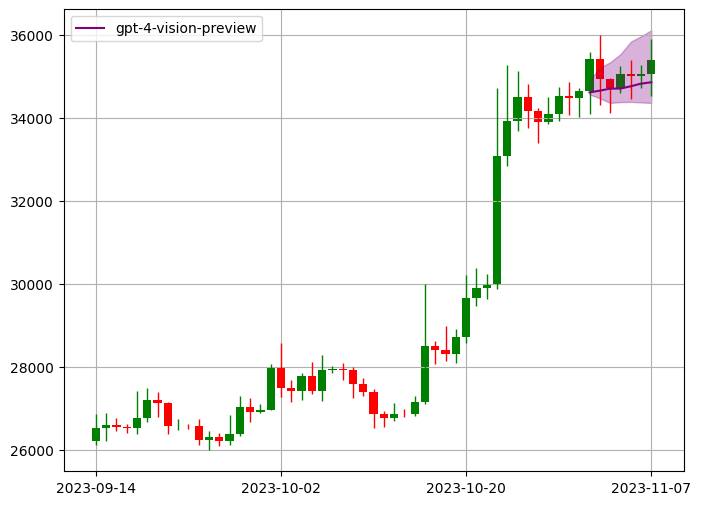

Input str :  29314, 29353, 29281, 29232, 29706, 29185, 29193, 29112, 29071, 29087, 29210, 29770, 29581, 29454, 29425, 29430, 29303, 29430, 29199, 28729, 26624, 26054, 26100, 26190, 26127, 26055, 26433, 26179, 26059, 26017, 26101, 26119, 27717, 27300, 25940, 25805, 25870, 25971, 25826, 25792, 25759, 26254, 25910, 25902, 25841, 25162, 25840, 26222, 26523, 26600, 26560, 26528, 26763, 27210, 27125, 26568, 26580, 26576, 26248, 26304, 26221, 26372, 27022, 26907, 26963, 27993, 27495, 27427, 27779, 27411, 27932, 27957, 27917, 27590, 27390, 26875, 26759, 26862, 26853, 27155, 28502, 28396, 28320, 28715, 29670, 29910, 29993, 33070, 33922, 34496, 34152, 33893, 34081, 34526, 34476, 34641, 
GPT Answer :  ['34562, 34407, 34328, 34587, 34547, 34612, 34533', '34687, 34604, 34566, 34482, 34340, 34241, 34199', '34624, 34621, 34617, 34608, 34606, 34522, 34442', '34770, 34964, 35689, 36171, 36507, 36839, 36923', '34606, 34585, 34529, 34589, 34896, 35076, 35021', '34623, 34456, 34278, 34214, 34189, 34154, 3

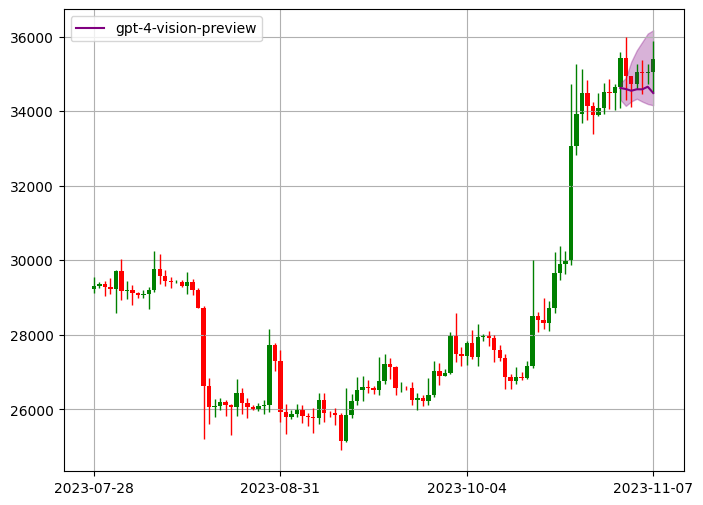

Input str :  27591, 27511, 28301, 28416, 29473, 29313, 29231, 29233, 28069, 28670, 29026, 28839, 29507, 28850, 28431, 27670, 27629, 27599, 26970, 26796, 26776, 26919, 27162, 27034, 27406, 26821, 26881, 27103, 26748, 26850, 27220, 26329, 26474, 26706, 26855, 28065, 27737, 27695, 27211, 26818, 27243, 27070, 27116, 25729, 27230, 26340, 26499, 26478, 25842, 25926, 25905, 25934, 25129, 25597, 26344, 26517, 26340, 26844, 28308, 29995, 29885, 30690, 30528, 30463, 30268, 30693, 30077, 30447, 30472, 30586, 30617, 31156, 30767, 30505, 29896, 30345, 30285, 30161, 30412, 30622, 30380, 31455, 30313, 30290, 30233, 30139, 29860, 29910, 29800, 29902, 29794, 30084, 29177, 29229, 29352, 29223, 29314, 29353, 29281, 29232, 29706, 29185, 29193, 29112, 29071, 29087, 29210, 29770, 29581, 29454, 29425, 29430, 29303, 29430, 29199, 28729, 26624, 26054, 26100, 26190, 26127, 26055, 26433, 26179, 26059, 26017, 26101, 26119, 27717, 27300, 25940, 25805, 25870, 25971, 25826, 25792, 25759, 26254, 25910, 25902, 25841, 

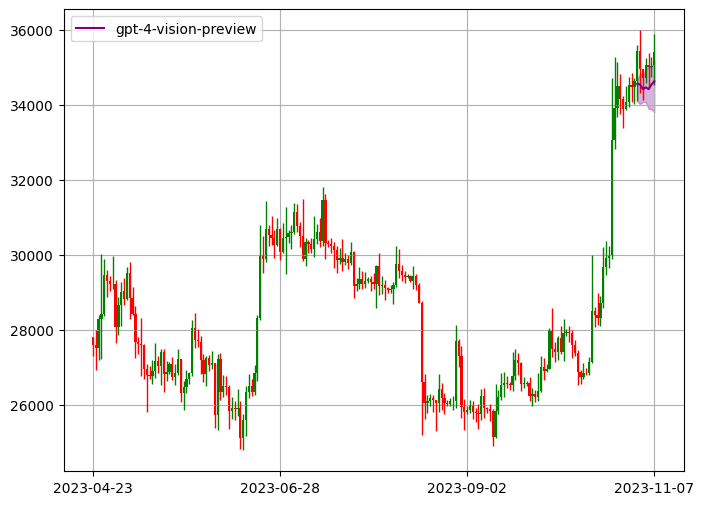

In [64]:
ending_predict_date = '2023-11-01'
ending_dates = ['2023-11-04', '2023-11-06', '2023-11-08']
index_save = 0
savefig = "naive/"


for input_length in [6, 12, 24, 48, 96, 192] :

    ending_predict_date_num = datetime.strptime(ending_predict_date, '%Y-%m-%d')
    new_date = ending_predict_date_num - timedelta(days=input_length)

    start_date = new_date.strftime('%Y-%m-%d')
    end_date = ending_dates[-1]

    df_raw, train, test = get_data_set("datasets/BTC_Daily_ohlc.csv", input_length, start_date, end_date)
    input_str = str_convert(train.values)

    print("Input str : ", input_str)
    list_response = request_gpt(input_str)
    print("GPT Answer : ", list_response)

    final_dic_int_list = basic_seriealize(list_response)
    print("serialized list : ", final_dic_int_list)

    index_save += 1
    current_folder = savefig + str(index_save)
    plot_preds_candles(df_raw, train, test, final_dic_int_list, "gpt-4-vision-preview", show_samples=False, savefig = current_folder)




Input str :  -100, -76, 56, 131, -15, 48, 
GPT Answer :  ['77, 210, -128, 12, 236, 72, -71', '187, 184, -67, 108, 239, 300, 61', '106, -94, 171, -168, 211, -232, 236', '-31, 172, 247, 101, 220, 73, 292', '113, 180, 60, 131, 88, 212, 115', '-188, -112, 19, 94, -53, 9, -228', '82, 171, 42, 196, -6, 221, 68', '-97, -23, 209, 284, 137, 200, 55', '-112, -90, 90, 165, -60, 80,', '-19, 111, 150, -31, 68, -3, 141']
error in serialization
int list return
[[77, 210, -128, 12, 236, 72, -71], [187, 184, -67, 108, 239, 300, 61], [106, -94, 171, -168, 211, -232, 236], [-31, 172, 247, 101, 220, 73, 292], [113, 180, 60, 131, 88, 212, 115], [-188, -112, 19, 94, -53, 9, -228], [82, 171, 42, 196, -6, 221, 68], [-97, -23, 209, 284, 137, 200, 55], [-19, 111, 150, -31, 68, -3, 141]]
int list, close
[[34907.47243382113, 35640.52935493137, 35184.33057918825, 35226.55177588328, 36057.898397794124, 36317.51526625825, 36059.660907867816], [35288.52056002142, 35937.82933832581, 35697.045881759026, 36082.573977282

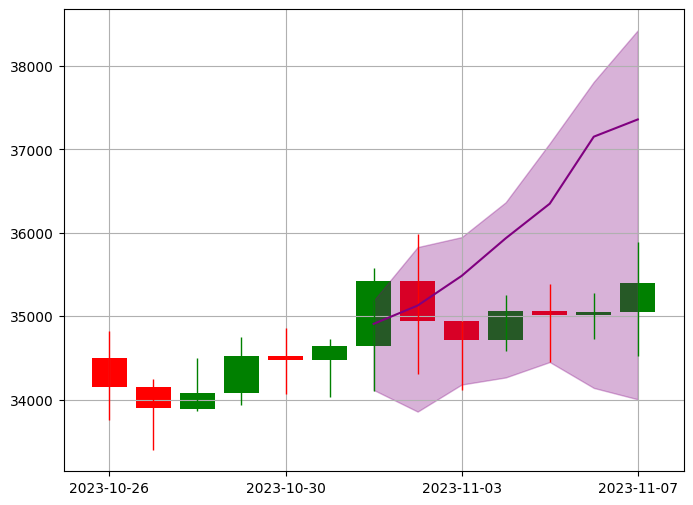

Input str :  333, 81, 28, 1026, 257, 169, -100, -76, 56, 131, -15, 48, 
GPT Answer :  ['-52, 63, -89, 84, -135, 105, -190', '-9, 24, 39, -33, 0, -3, 12', '-132, 165, -143, 40, -160, 169, -171', '75, -174, 442, 80, 52, -119, -92', '-67, 63, -57, 72, -39, 81, -15', '-43, 99, 24, 74, -70, 69, -26', '-53, 81, -91, 114, -129, 147, -167', '68, -4, 64, 60, -8, 60, 52', '-49, -23, 25, 19, -10', '-142, 230, -308, 329, -511, 428, -751']
int list return
[[-52, 63, -89, 84, -135, 105, -190], [-9, 24, 39, -33, 0, -3, 12], [-132, 165, -143, 40, -160, 169, -171], [75, -174, 442, 80, 52, -119, -92], [-67, 63, -57, 72, -39, 81, -15], [-43, 99, 24, 74, -70, 69, -26], [-53, 81, -91, 114, -129, 147, -167], [68, -4, 64, 60, -8, 60, 52], [-49, -23, 25, 19, -10, -10, -10], [-142, 230, -308, 329, -511, 428, -751]]
int list, close
[[34460.60690400443, 34677.70872749966, 34369.07711982491, 34657.77736763144, 34189.89737316842, 34548.89129558668, 33892.46236097054], [34609.56208061, 34692.62502960346, 34827.9262

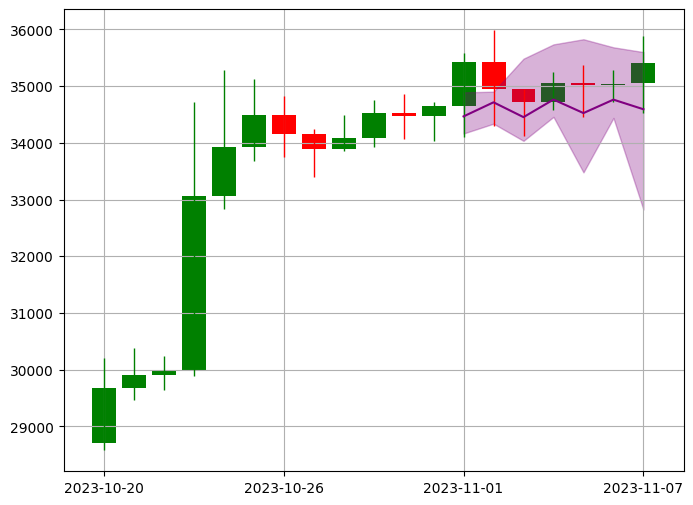

Input str :  -14, -117, -73, -188, -43, 39, -4, 113, 496, -37, -27, 139, 333, 81, 28, 1026, 257, 169, -100, -76, 56, 131, -15, 48, 
GPT Answer :  ["Depending on the pattern you're looking for, providing a continuation with absolute accuracy might be a complex task because the sequence provided does not follow a clear arithmetic or geometric pattern that can be easily discerned and extended. If the sequence is the result of a more complex function or has some hidden pattern not evident by the numbers themselves, there's not enough information to accurately predict the next terms. However, if you have a certain rule or pattern in mind that these numbers follow, please provide it so the upcoming sequence can be accurately predicted.", '-97, -37, 132, 247, 105, 90, 1066', '311, -284, 227, 609, 360, 624, 1569', '209, 121, -38, -31, 75, 152, 6', '491, 237, 222, -243, -219, 13, 168', '115, -3, -62, 189, 594, 171, 130', '1003, 134, 194, -97, -79, 71, 202', '575, -85, 144, 108, 91, 67, 341', '7

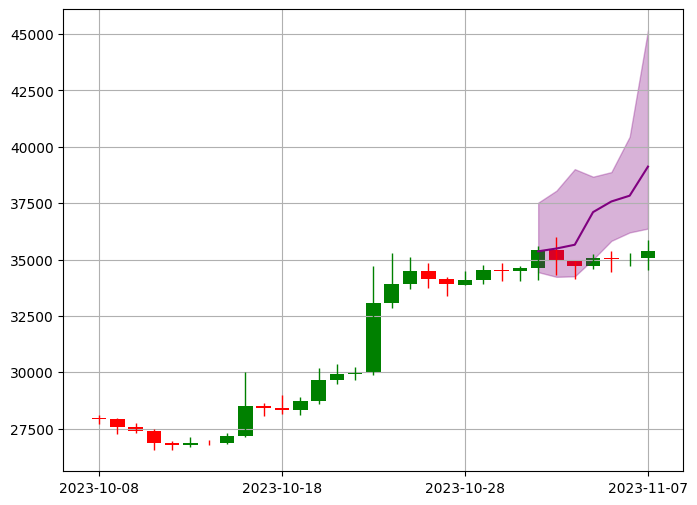

Input str :  115, 29, -15, -12, 89, 167, -31, -205, 5, -1, -123, 22, -32, 58, 246, -42, 21, 382, -178, -25, 128, -133, 190, 9, -14, -117, -73, -188, -43, 39, -4, 113, 496, -37, -27, 139, 333, 81, 28, 1026, 257, 169, -100, -76, 56, 131, -15, 48, 
GPT Answer :  ['-14, 9, 528, 294, 101, -97, -82', '-221, -9, -217, -29, 172, 63, 41', '-122, -44, -181, 40, 21, -3, 1048', '-452, -129, -131, -235, 165, 263, 2', '-194, -72, -29, 272, 183, 15, -14', '-29, -11, 197, 102, 348, 121, 64', '75, 221, -92, 89, 281, 118, 175', '617, -74, 33, 92, -8, 25, 58', '738, -66, 61, 2349, 965, 717, -226', '-1024, -49, 170, -38, 29, 241, 42']
int list return
[[-14, 9, 528, 294, 101, -97, -82], [-221, -9, -217, -29, 172, 63, 41], [-122, -44, -181, 40, 21, -3, 1048], [-452, -129, -131, -235, 165, 263, 2], [-194, -72, -29, 272, 183, 15, -14], [-29, -11, 197, 102, 348, 121, 64], [75, 221, -92, 89, 281, 118, 175], [617, -74, 33, 92, -8, 25, 58], [738, -66, 61, 2349, 965, 717, -226], [-1024, -49, 170, -38, 29, 241, 42]

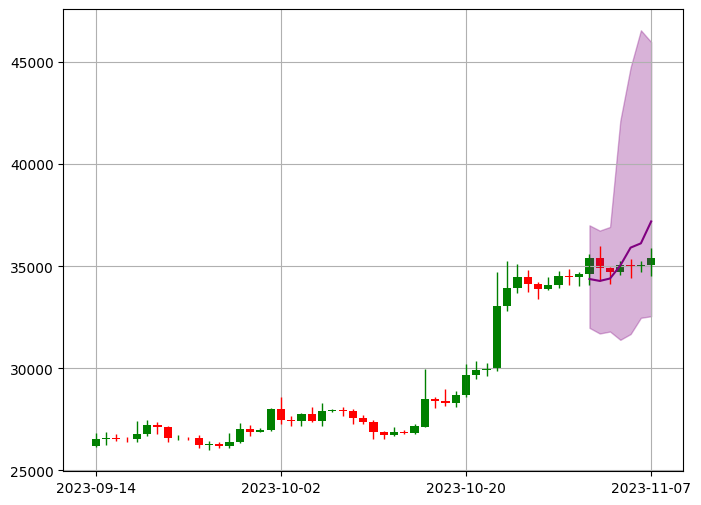

Input str :  31, 13, -25, -17, 162, -175, 3, -28, -14, 5, 42, 192, -64, -43, -10, 2, -43, 43, -79, -161, -733, -214, 18, 35, -24, -27, 145, -96, -46, -16, 32, 7, 612, -150, -498, -52, 25, 39, -56, -13, -12, 192, -131, -3, -23, -263, 269, 148, 115, 29, -15, -12, 89, 167, -31, -205, 5, -1, -123, 22, -32, 58, 246, -42, 21, 382, -178, -25, 128, -133, 190, 9, -14, -117, -73, -188, -43, 39, -4, 113, 496, -37, -27, 139, 333, 81, 28, 1026, 257, 169, -100, -76, 56, 131, -15, 48, 
GPT Answer :  ['-174, -523, -21, -5, -47, -131, -158', '-64, 412, -197, -73, -14, 259, -147', '-987, -1092, -161, 71, -8, 9, -19', '-22, -140, 263, -65, -33, 20, 234', '-101, 264, -186, -34, -47, 139, 81', '-83, -60, 32, -88, -29, 17, -736', '-39, -12, 318, -169, -36, 83, 346', '-57, -167, 17, -54, 72, 288, -48', '-107, -82, 812, -351, 163, 20, 39', '207, 29, -75, -227, -94, 188, -11']
int list return
[[-174, -523, -21, -5, -47, -131, -158], [-64, 412, -197, -73, -14, 259, -147], [-987, -1092, -161, 71, -8, 9, -19], [-

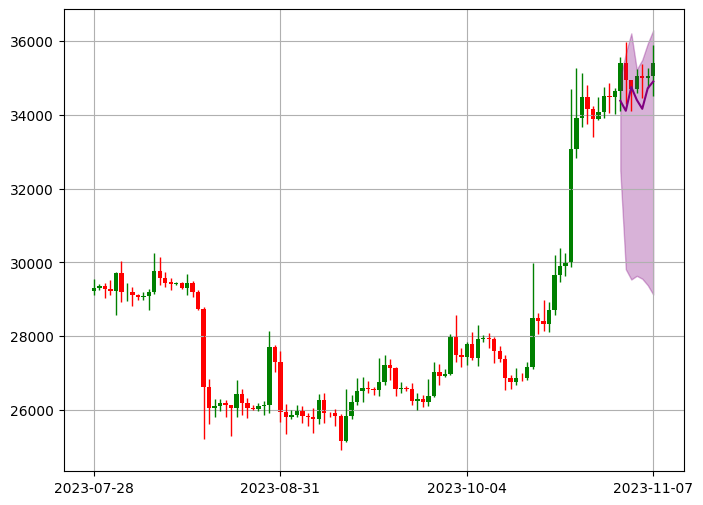

Input str :  -81, -29, 287, 41, 372, -55, -28, 1, -399, 214, 124, -65, 232, -222, -145, -268, -15, -11, -228, -64, -8, 53, 91, -47, 137, -213, 22, 83, -131, 38, 138, -327, 55, 88, 56, 451, -117, -15, -175, -144, 158, -64, 17, -511, 584, -327, 61, -8, -240, 33, -8, 11, -311, 187, 292, 65, -67, 192, 545, 596, -37, 269, -52, -21, -64, 140, -200, 123, 8, 37, 10, 176, -125, -85, -199, 150, -20, -41, 83, 69, -79, 354, -363, -7, -19, -31, -92, 17, -37, 34, -36, 97, -302, 18, 42, -44, 31, 13, -25, -17, 162, -175, 3, -28, -14, 5, 42, 192, -64, -43, -10, 2, -43, 43, -79, -161, -733, -214, 18, 35, -24, -27, 145, -96, -46, -16, 32, 7, 612, -150, -498, -52, 25, 39, -56, -13, -12, 192, -131, -3, -23, -263, 269, 148, 115, 29, -15, -12, 89, 167, -31, -205, 5, -1, -123, 22, -32, 58, 246, -42, 21, 382, -178, -25, 128, -133, 190, 9, -14, -117, -73, -188, -43, 39, -4, 113, 496, -37, -27, 139, 333, 81, 28, 1026, 257, 169, -100, -76, 56, 131, -15, 48, 
GPT Answer :  ['-62, -114, 119, 160, -23, -87, 29', '-1

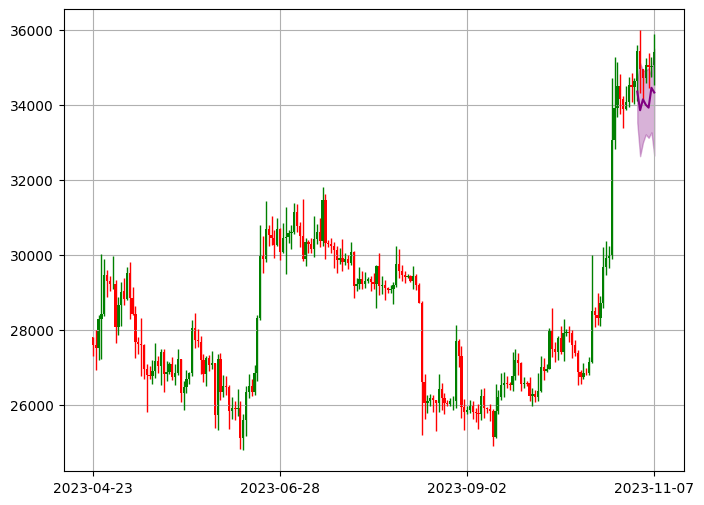

In [52]:
ending_predict_date = '2023-11-01'
ending_dates = ['2023-11-04', '2023-11-06', '2023-11-08']
index_save = 0
savefig = "return/"


for input_length in [6, 12, 24, 48, 96, 192] :

    ending_predict_date_num = datetime.strptime(ending_predict_date, '%Y-%m-%d')
    new_date = ending_predict_date_num - timedelta(days=input_length)

    start_date = new_date.strftime('%Y-%m-%d')
    end_date = ending_dates[-1]

    df_raw, train, test = get_data_set_return("datasets/BTC_Daily_ohlc.csv", input_length, start_date, end_date)
    input_str = str_convert(train.values)

    print("Input str : ", input_str)
    list_response = request_gpt(input_str)
    print("GPT Answer : ", list_response)

    final_dic_int_list = basic_seriealize(list_response)
    print("int list return")
    print(final_dic_int_list)
    
    final_dic = convert_return_to_close(final_dic_int_list, df_raw, input_length)
    print("int list, close")
    print(final_dic)

    index_save += 1
    current_folder = savefig + str(index_save)
    plot_preds_candles(df_raw, train, test, final_dic, "gpt-4-vision-preview", show_samples=False,  savefig = current_folder)

Input str :  34152, 33893, 34081, 34526, 34476, 34641, 
GPT Answer :  ['D2, U2, U4, D2, U2, U4, D2', 'D2, U2, U4, D2, U2, U2, U4', 'D2, U2, U4, D2, U2, U2, D2', 'D2, D2, U2, D2, U2, U2, U2', 'D2, U2, U4, D2, U2, U4, D2', 'D2, U2, U4, D2, U2, U2, U4', 'D2, U2, U2, D2, U2, U2, D2', 'D2, U2, D2, U2, D2, U2, D2', 'D2, D2, D2, D2, D2, D2, D2', 'D2, U2, U4, D4, D2, U2, U4']
serialized :  [[-1, 1, 3, -1, 1, 3, -1], [-1, 1, 3, -1, 1, 1, 3], [-1, 1, 3, -1, 1, 1, -1], [-1, -1, 1, -1, 1, 1, 1], [-1, 1, 3, -1, 1, 3, -1], [-1, 1, 3, -1, 1, 1, 3], [-1, 1, 1, -1, 1, 1, -1], [-1, 1, -1, 1, -1, 1, -1], [-1, -1, -1, -1, -1, -1, -1], [-1, 1, 3, -3, -1, 1, 3]]
int list, close
[[34294, 34636, 35675, 35318, 35671, 36741, 36373], [34294, 34636, 35675, 35318, 35671, 36027, 37107], [34294, 34636, 35675, 35318, 35671, 36027, 35666], [34294, 33951, 34290, 33947, 34286, 34628, 34974], [34294, 34636, 35675, 35318, 35671, 36741, 36373], [34294, 34636, 35675, 35318, 35671, 36027, 37107], [34294, 34636, 34982, 34632,

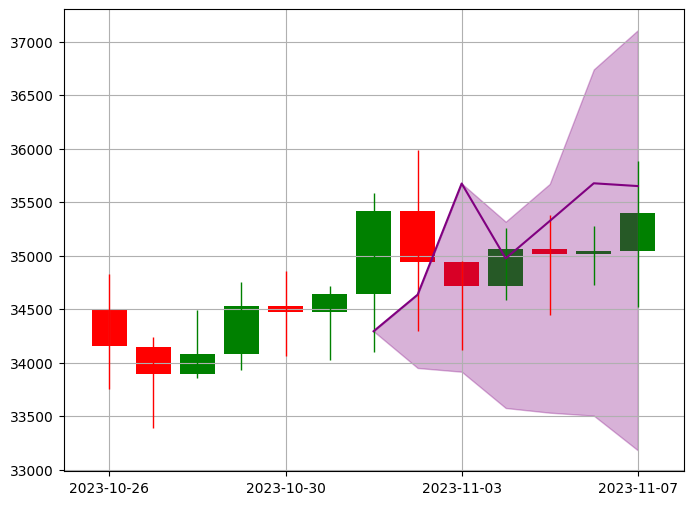

Input str :  29670, 29910, 29993, 33070, 33922, 34496, 34152, 33893, 34081, 34526, 34476, 34641, 
GPT Answer :  ['U2, U2, D2, D2, U2, U2, U2', 'D2, D2, U2, U2, U2, U2, U2', 'D2, D4, D2, U2, D2, D4, D2', 'D2, D2, U2, U2, U2, U2, U2', 'U2, U2, U4, U4, U4, U4, U4', 'U2, U2, D2, D2, D2, D2, U2', 'D2, D2, U2, U2, U2, U2, U2', 'D2, D4, U2, U2, D2, D2, U2', 'U2, U2, U2, U2, U2, U2, U2', 'D2, D2, U2, U2, U2, U2, U2']
serialized :  [[1, 1, -1, -1, 1, 1, 1], [-1, -1, 1, 1, 1, 1, 1], [-1, -3, -1, 1, -1, -3, -1], [-1, -1, 1, 1, 1, 1, 1], [1, 1, 3, 3, 3, 3, 3], [1, 1, -1, -1, -1, -1, 1], [-1, -1, 1, 1, 1, 1, 1], [-1, -3, 1, 1, -1, -1, 1], [1, 1, 1, 1, 1, 1, 1], [-1, -1, 1, 1, 1, 1, 1]]
int list, close
[[34987, 35336, 34982, 34632, 34978, 35327, 35680], [34294, 33951, 34290, 34632, 34978, 35327, 35680], [34294, 33265, 32932, 33261, 32928, 31940, 31620], [34294, 33951, 34290, 34632, 34978, 35327, 35680], [34987, 35336, 36396, 37487, 38611, 39769, 40962], [34987, 35336, 34982, 34632, 34285, 33942, 342

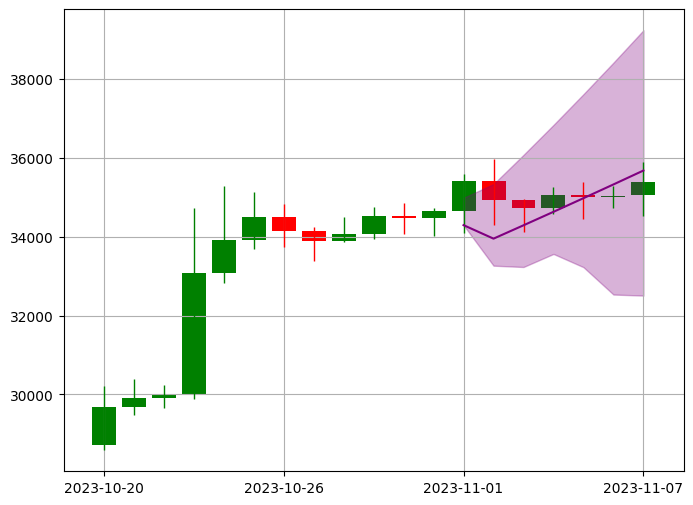

Input str :  27917, 27590, 27390, 26875, 26759, 26862, 26853, 27155, 28502, 28396, 28320, 28715, 29670, 29910, 29993, 33070, 33922, 34496, 34152, 33893, 34081, 34526, 34476, 34641, 
GPT Answer :  ['D2, D2, D4, D6, D2, U2, U4', 'D2, D4, U2, U2, U4, U4, U6', 'D2, D4, D2, U2, U2, U2, U2', 'U2, U2, U2, D2, D2, D2, D4', 'D2, D2, D4, U2, U2, U4, U4', 'U2, U4, U2, U2, U2, U4, U6', 'D2, U2, U2, D2, D2, D4, D4', 'D2, D4, D2, U2, D2, D2, U2', 'D2, D4, U2, U2, D2, D2, D4', 'U2, U2, D2, D2, U2, U2, U2']
serialized :  [[-1, -1, -3, -5, -1, 1, 3], [-1, -3, 1, 1, 3, 3, 5], [-1, -3, -1, 1, 1, 1, 1], [1, 1, 1, -1, -1, -1, -3], [-1, -1, -3, 1, 1, 3, 3], [1, 3, 1, 1, 1, 3, 5], [-1, 1, 1, -1, -1, -3, -3], [-1, -3, -1, 1, -1, -1, 1], [-1, -3, 1, 1, -1, -1, -3], [1, 1, -1, -1, 1, 1, 1]]
int list, close
[[34294, 33951, 32932, 31285, 30972, 31281, 32219], [34294, 33265, 33597, 33932, 34949, 35997, 37796], [34294, 33265, 32932, 33261, 33593, 33928, 34267], [34987, 35336, 35689, 35332, 34978, 34628, 33589], [34

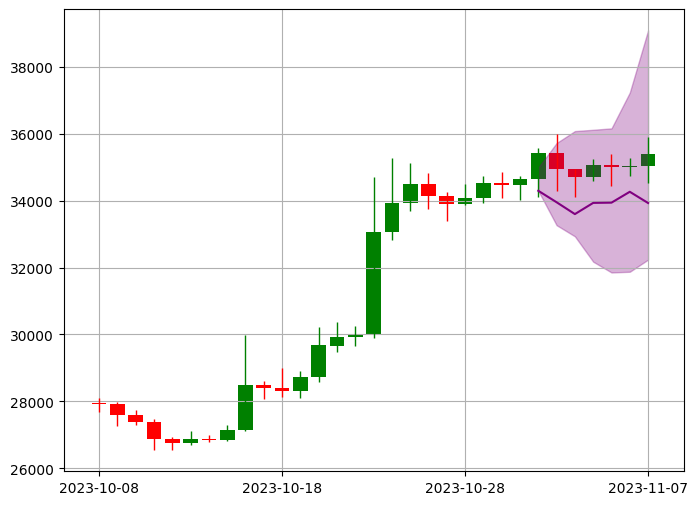

Input str :  26523, 26600, 26560, 26528, 26763, 27210, 27125, 26568, 26580, 26576, 26248, 26304, 26221, 26372, 27022, 26907, 26963, 27993, 27495, 27427, 27779, 27411, 27932, 27957, 27917, 27590, 27390, 26875, 26759, 26862, 26853, 27155, 28502, 28396, 28320, 28715, 29670, 29910, 29993, 33070, 33922, 34496, 34152, 33893, 34081, 34526, 34476, 34641, 
GPT Answer :  ['U2, U2, U4, U4, U6, U8, U10', 'D2, D4, D6, D8, D10, D10+, D10+', 'D2, U2, U4, D2, D4, D6, D8', 'U2, U2, U4, U4, U6, U8, U10', 'D2, D4, D2, U2, U4, U2, D2', 'D2, D2, D4, D4, D6, D6, D8', 'U4, U2, D2, D4, D6, D8, D10', 'D2, D4, D6, D8, D10, D10+, U2', 'U2, U4, U6, U8, U10, U10+, U10+', 'U2, D2, D4, D6, D8, D10, D10+']
serialized :  [[1, 1, 3, 3, 5, 7, 9], [-1, -3, -5, -7, -9, -11, -11], [-1, 1, 3, -1, -3, -5, -7], [1, 1, 3, 3, 5, 7, 9], [-1, -3, -1, 1, 3, 1, -1], [-1, -1, -3, -3, -5, -5, -7], [3, 1, -1, -3, -5, -7, -9], [-1, -3, -5, -7, -9, -11, 1], [1, 3, 5, 7, 9, 11, 11], [1, -1, -3, -5, -7, -9, -11]]
int list, close
[[34987, 

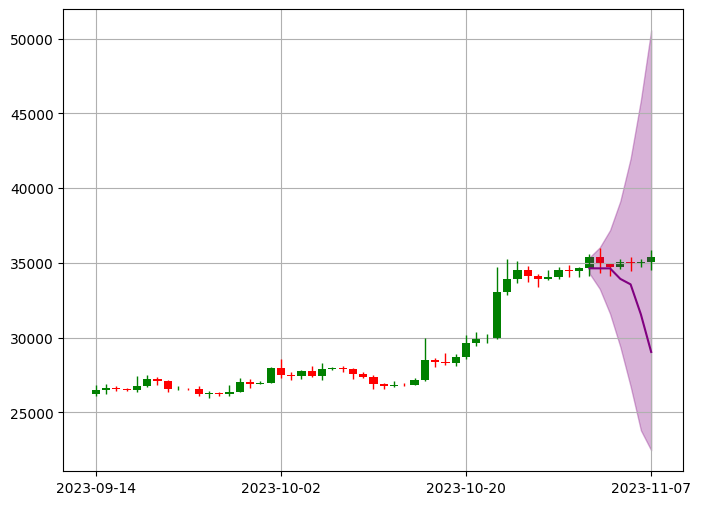

Input str :  29314, 29353, 29281, 29232, 29706, 29185, 29193, 29112, 29071, 29087, 29210, 29770, 29581, 29454, 29425, 29430, 29303, 29430, 29199, 28729, 26624, 26054, 26100, 26190, 26127, 26055, 26433, 26179, 26059, 26017, 26101, 26119, 27717, 27300, 25940, 25805, 25870, 25971, 25826, 25792, 25759, 26254, 25910, 25902, 25841, 25162, 25840, 26222, 26523, 26600, 26560, 26528, 26763, 27210, 27125, 26568, 26580, 26576, 26248, 26304, 26221, 26372, 27022, 26907, 26963, 27993, 27495, 27427, 27779, 27411, 27932, 27957, 27917, 27590, 27390, 26875, 26759, 26862, 26853, 27155, 28502, 28396, 28320, 28715, 29670, 29910, 29993, 33070, 33922, 34496, 34152, 33893, 34081, 34526, 34476, 34641, 
GPT Answer :  ['U2, U2, U2, U2, U2, U2, U2', 'D2, D2, D4, U2, U2, U4, U2', 'D2, D2, D4, D4, D2, D2, U2', 'U2, U4, U6, U8, U10, U10+, U10', 'D2, D4, D6, D8, D10, D10+, U2', 'D2, D4, D6, D8, D10, D10+, D10+', 'U2, U2, D2, D4, D6, D8, D10', 'U2, U2, D2, D4, D6, D8, D10', 'U2, U2, U2, D2, D2, D4, D6', 'D2, D4, D6, D8

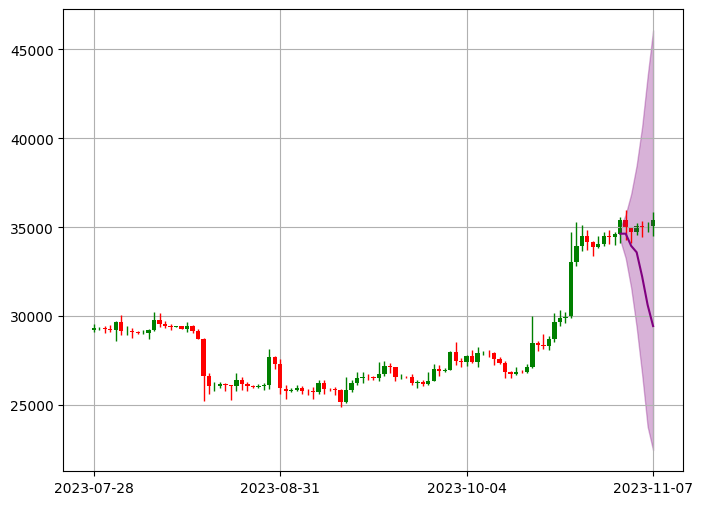

Input str :  27591, 27511, 28301, 28416, 29473, 29313, 29231, 29233, 28069, 28670, 29026, 28839, 29507, 28850, 28431, 27670, 27629, 27599, 26970, 26796, 26776, 26919, 27162, 27034, 27406, 26821, 26881, 27103, 26748, 26850, 27220, 26329, 26474, 26706, 26855, 28065, 27737, 27695, 27211, 26818, 27243, 27070, 27116, 25729, 27230, 26340, 26499, 26478, 25842, 25926, 25905, 25934, 25129, 25597, 26344, 26517, 26340, 26844, 28308, 29995, 29885, 30690, 30528, 30463, 30268, 30693, 30077, 30447, 30472, 30586, 30617, 31156, 30767, 30505, 29896, 30345, 30285, 30161, 30412, 30622, 30380, 31455, 30313, 30290, 30233, 30139, 29860, 29910, 29800, 29902, 29794, 30084, 29177, 29229, 29352, 29223, 29314, 29353, 29281, 29232, 29706, 29185, 29193, 29112, 29071, 29087, 29210, 29770, 29581, 29454, 29425, 29430, 29303, 29430, 29199, 28729, 26624, 26054, 26100, 26190, 26127, 26055, 26433, 26179, 26059, 26017, 26101, 26119, 27717, 27300, 25940, 25805, 25870, 25971, 25826, 25792, 25759, 26254, 25910, 25902, 25841, 

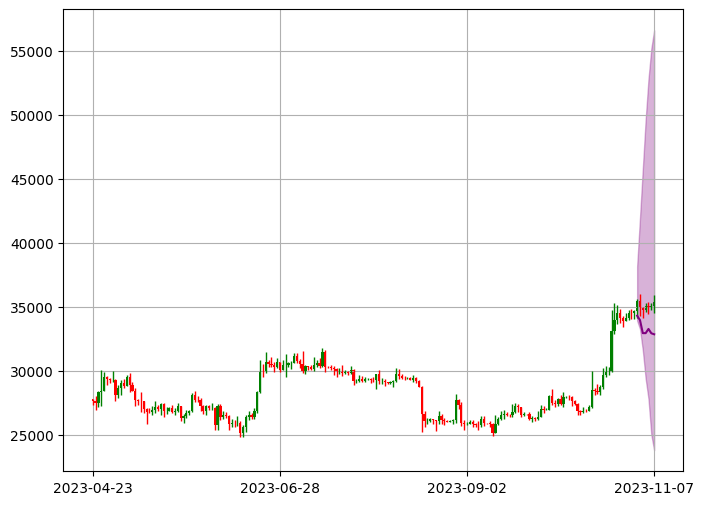

In [62]:
ending_predict_date = '2023-11-01'
ending_dates = ['2023-11-04', '2023-11-06', '2023-11-08']
index_save = 0
savefig = "bin/"

for input_length in [6, 12, 24, 48, 96, 192] :

    ending_predict_date_num = datetime.strptime(ending_predict_date, '%Y-%m-%d')
    new_date = ending_predict_date_num - timedelta(days=input_length)

    start_date = new_date.strftime('%Y-%m-%d')
    end_date = ending_dates[-1]

    df_raw, train, test = get_data_set("datasets/BTC_Daily_ohlc.csv", input_length, start_date, end_date)
    input_str = str_convert(train.values)

    print("Input str : ", input_str)
    list_response = request_gpt_bin(input_str)
    print("GPT Answer : ", list_response)

    final_dic_int_list = bin_seriealize(list_response)
    print("serialized : ", final_dic_int_list)

    final_dic = convert_bin_to_close(final_dic_int_list, df_raw, input_length)
    print("int list, close")
    print(final_dic)

    index_save += 1
    current_folder = savefig + str(index_save)
    plot_preds_candles(df_raw, train, test, final_dic, "gpt-4-vision-preview", show_samples=False, savefig= current_folder )


